In [ ]:
!git clone https://github.com/AvonYangXX1/DreamWalker.git
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

Cloning into 'DreamWalker'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 468 (delta 19), reused 111 (delta 16), pack-reused 353
Receiving objects: 100% (468/468), 1.37 GiB | 16.23 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (130/130), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_cv_data(i, onehot=True):
    path = "DreamWalker/data/processed_data/AMP"
    pep_train = np.load(f"{path}/pep_train_{i}.npz")["data"].astype("float32")
    target_train = np.load(f"{path}/target_train_{i}.npz")["data"].astype("float32")
    label_train = np.load(f"{path}/label_train_{i}.npz")["data"].astype("float32")
    pep_val = np.load(f"{path}/pep_val_{i}.npz")["data"].astype("float32")
    target_val = np.load(f"{path}/target_val_{i}.npz")["data"].astype("float32")
    label_val = np.load(f"{path}/label_val_{i}.npz")["data"].astype("float32")
    if onehot:
        pep_train = tf.one_hot(pep_train, depth=43)
        pep_val = tf.one_hot(pep_val, depth=43)
    return pep_train, target_train, label_train, pep_val, target_val, label_val

In [ ]:
# class MultiHeadAttention(tf.keras.layers.Layer):
#     def __init__(self, d_model, num_heads):
#         super(MultiHeadAttention, self).__init__()
#         self.num_heads = num_heads
#         self.d_model = d_model
#         assert d_model % self.num_heads == 0
#         self.depth = d_model // self.num_heads
#         self.wq = tf.keras.layers.Dense(d_model)
#         self.wk = tf.keras.layers.Dense(d_model)
#         self.wv = tf.keras.layers.Dense(d_model)
#         self.dense = tf.keras.layers.Dense(d_model)
#         self.attention_weights = None

#     def split_heads(self, x, batch_size):
#         x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
#         return tf.transpose(x, perm=[0, 2, 1, 3])

#     def scaled_dot_product_attention(self, q, k, v, mask):
#         matmul_qk = tf.matmul(q, k, transpose_b=True)
#         depth = tf.cast(tf.shape(k)[-1], tf.float32)
#         logits = matmul_qk / tf.math.sqrt(depth)
#         if mask is not None:
#             logits += (mask * -1e9)
#         self.attention_weights = tf.nn.softmax(logits, axis=-1)
#         output = tf.matmul(self.attention_weights, v)
#         return output

#     def call(self, v, k, q, mask):
#         batch_size = tf.shape(q)[0]
#         q = self.wq(q)
#         k = self.wk(k)
#         v = self.wv(v)
#         q = self.split_heads(q, batch_size)
#         k = self.split_heads(k, batch_size)
#         v = self.split_heads(v, batch_size)
#         scaled_attention = self.scaled_dot_product_attention(q, k, v, mask)
#         scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
#         concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
#         output = self.dense(concat_attention)
#         return output

# class DecoderLayer(tf.keras.layers.Layer):
#     def __init__(self, d_model, num_heads, dff, rate=0.1):
#         super(DecoderLayer, self).__init__()
#         self.mha = MultiHeadAttention(d_model, num_heads)
#         self.ffn = self.point_wise_feed_forward_network(d_model, dff)
#         self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
#         self.dropout1 = tf.keras.layers.Dropout(rate)
#         self.dropout2 = tf.keras.layers.Dropout(rate)

#     def point_wise_feed_forward_network(self, d_model, dff):
#         return tf.keras.Sequential([
#             tf.keras.layers.Dense(dff, activation='relu'),
#             tf.keras.layers.Dense(d_model)
#         ])

#     def call(self, x, mask=None):
#         attn_output = self.mha(x, x, x, mask)
#         attn_output = self.dropout1(attn_output)
#         out1 = self.layernorm1(x + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output)
#         out2 = self.layernorm2(out1 + ffn_output)
#         return out2

# def get_positional_encoding(seq_length, d_model):
#     pos = np.arange(seq_length)[:, np.newaxis]
#     i = np.arange(d_model)[np.newaxis, :]
#     angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
#     angle_rads = pos * angle_rates
#     sines = np.sin(angle_rads[:, 0::2])
#     cosines = np.cos(angle_rads[:, 1::2])
#     pos_encoding = np.concatenate([sines, cosines], axis=-1)[np.newaxis, ...]
#     return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_classifier():
    path = "DreamWalker/model_weights"
    vocab_size = 3982
    length = 19
    encoder_inputs = tf.keras.layers.Input(shape=(1024,))
    x = tf.keras.layers.RepeatVector(length, name="RepeatVector")(encoder_inputs)
    x = tf.keras.layers.GRU(1024, return_sequences=True, dropout=0.2, name="GRU0")(x)
    x = tf.keras.layers.GRU(1024, return_sequences=True, dropout=0.2, name="GRU1")(x)
    x = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
    classifier = tf.keras.models.Model(encoder_inputs,x)
    classifier.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                       loss='sparse_categorical_crossentropy',metrics=["accuracy"])
    for i, layer in enumerate(classifier.layers):
        weights = np.load(f"{path}/ClassifierWeights/layer_{i}_weights.npz", allow_pickle=True)["weights"]
        layer.set_weights(weights)
        layer.trainable = False
    return classifier

In [ ]:
def create_model(seq_len=40):
    inputs0 = tf.keras.layers.Input((seq_len, 43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((1024,),name="BacteriaInput")
    # Extract Peptide Features
    x0 = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x0 = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x0) # Just two layers work better
    x0 = tf.keras.layers.Flatten(name="Flatten_CNN")(x0)
    x0 = tf.keras.layers.Dense(512, activation="relu", name="CNN_Dense0")(x0)

    # Target Marker Gene Representation
    classifier = create_classifier()
    MarkerRepresentModule = tf.keras.models.Model(classifier.layers[0].input,
                                                  classifier.layers[-1].output,
                                                  name="ClassifierModule")
    x1 = MarkerRepresentModule(inputs1)
    x1 = tf.keras.layers.Conv1D(128, 4, activation='relu', name="Conv1D_GRU0")(x1)
    x1 = tf.keras.layers.Flatten(name="Flatten_GRU")(x1)
    x1 = tf.keras.layers.Dense(512, activation="relu", name="GRU_DenseLast")(x1) # mimic the previous version

    # FCN
    x = tf.keras.layers.Concatenate(axis=1, name="Concat_FCN")([x0, x1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="FCN_Dense0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="FCN_Dense1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    output0 = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid, name="C_Output")(x)

    model = tf.keras.models.Model([inputs0, inputs1], output0, name="Oracle")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=combined_loss,
                  metrics=[tf.keras.metrics.R2Score()])
    return model

In [ ]:
# def create_model(seq_len=40, d_model=128):
#     inputs0 = tf.keras.layers.Input((seq_len, 43),name="SeqInput")
#     inputs1 = tf.keras.layers.Input((1024,),name="BacteriaInput")
#     pos_enc = get_positional_encoding(seq_len, d_model)

#     # Extract Peptide Features
#     # x0 = tf.keras.layers.Embedding(seq_len, d_model, name="Emb")(inputs0)
#     x0 = tf.keras.layers.Conv1D(d_model, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
#     x0 = tf.keras.layers.Conv1D(d_model, 5, activation='relu', name="Conv1D_1")(x0) # Just two layers work better

#     # Target Marker Gene Representation
#     classifier = create_classifier()
#     MarkerRepresentModule = tf.keras.models.Model(classifier.layers[0].input,
#                                                   classifier.layers[-1].output,
#                                                   name="ClassifierModule")
#     x1 = MarkerRepresentModule(inputs1)
#     x1 = tf.keras.layers.Conv1D(d_model, 4, activation='relu', name="Conv1D_GRU0")(x1)

#     # x2 = tf.keras.layers.Concatenate(axis=1, name="Concat_Origin")([x0, x1])
#     x = tf.keras.layers.Concatenate(axis=1, name="Concat_Decoder")([x0 + pos_enc[:, 32, :], x1 + pos_enc[:, 19, :]])

#     for i in range(3):
#         transformer = DecoderLayer(d_model, 8, 128)
#         transformer._name = f"Decoder_{i}"
#         x = transformer(x)

#     # x = tf.keras.layers.Add(name="ResConnect")([x, x2])

#     x = tf.keras.layers.Flatten(name="DecoderFlatten")(x)
#     x = tf.keras.layers.Dense(1024, activation="relu", name="FCN_Dense0")(x)
#     x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
#     x = tf.keras.layers.Dense(512, activation="relu", name="FCN_Dense1")(x)
#     x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
#     output0 = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid, name="C_Output")(x)
#     model = tf.keras.models.Model([inputs0, inputs1], output0, name="Oracle")

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                   loss=combined_loss,
#                   metrics=tf.keras.metrics.R2Score())
#     return model

In [ ]:
def combined_loss(y_true, y_pred):
    # Create masks for positive and negative samples
    mask0 = y_true == 1
    mask1 = y_true != 1

    # Apply masks to select data
    y_true_0, y_pred_0 = y_true[mask0], y_pred[mask0]
    y_true_1, y_pred_1 = y_true[mask1], y_pred[mask1]

    # Calculate losses for positive and negative samples
    loss_0 = tf.keras.losses.BinaryCrossentropy()(y_true_0, y_pred_0)
    loss_1 = tf.keras.losses.MeanAbsoluteError()(y_true_1, y_pred_1)

    w0 = tf.cast(tf.size(y_true_0), tf.float32) / tf.cast(tf.size(y_true), tf.float32)
    w1 = tf.cast(tf.size(y_true_1), tf.float32) / tf.cast(tf.size(y_true), tf.float32) * 10

    # Combine losses
    combined =  w0 * loss_0 + w1 * loss_1
    return combined

In [ ]:
metric = []
for i in range(5):
    pep_train, target_train, label_train, pep_val, target_val, label_val = read_cv_data(i, onehot=True)
    model = create_model()
    model.fit([pep_train, target_train], label_train, batch_size=32, verbose=0, epochs=30,
              validation_data=([pep_val, target_val], label_val))
    r_pred = model.predict([pep_val, target_val], verbose=0)
    metric.append(r2_score(label_val, r_pred))
    print(metric[i])
    del pep_train, target_train, label_train, pep_val, target_val, label_val
print(f"Mean R2={np.mean(metric):4f}")

0.7988888046155872
0.7889945504771454
0.793438901649563
0.7803817303162828
0.8006487605540134
Mean R2=0.792471


In [ ]:
path = "DreamWalker/data/processed_data/AMP"
pep_train = np.load(f"{path}/pep_cv.npz")["data"].astype("float32")
target_train = np.load(f"{path}/target_cv.npz")["data"].astype("float32")
label_train = np.load(f"{path}/label_cv.npz")["data"].astype("float32")
pep_test = np.load(f"{path}/pep_test.npz")["data"].astype("float32")
target_test = np.load(f"{path}/target_test.npz")["data"].astype("float32")
label_test = np.load(f"{path}/label_test.npz")["data"].astype("float32")
pep_train = tf.one_hot(pep_train, depth=43)
pep_test = tf.one_hot(pep_test, depth=43)

In [ ]:
model = create_model()
model.fit([pep_train, target_train], label_train, batch_size=32, verbose=0, epochs=30,
          validation_data=([pep_test, target_test], label_test))
r_pred = model.predict([pep_test, target_test], verbose=0)
r2 = r2_score(label_test, r_pred)
print(f"R2={r2:4f}")

R2=0.814574


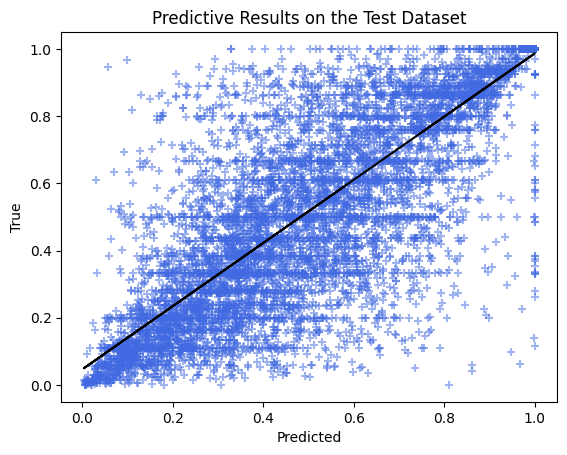

In [ ]:
meta = LinearRegression()
x = r_pred
y = label_test
meta.fit(x, y)
line = meta.predict(x)
fig, axs = plt.subplots(1,1)
axs.scatter(x, y, marker="+", color="royalblue", alpha=0.5)
axs.plot(x, line, color="black")
axs.set_xlabel("Predicted")
axs.set_ylabel("True")
axs.set_title("Predictive Results on the Test Dataset")
plt.savefig("oracle_performance.png")

In [ ]:
pep = np.load(f"{path}/pep_whole.npz")["data"].astype("float32")
target = np.load(f"{path}/target_whole.npz")["data"].astype("float32")
label = np.load(f"{path}/label_whole.npz")["data"].astype("float32")
pep = tf.one_hot(pep, depth=43)

In [ ]:
model = create_model()
model.fit([pep, target], label, batch_size=32, verbose=0, epochs=20)

In [ ]:
path = "drive/MyDrive/DreamWalker/model_weights/OracleWeights"
for i, layer in enumerate(model.layers):
    param = layer.get_weights()
    if len(param) == 0:
        continue
    weights = param[0]
    biases = param[1]
    np.savez_compressed(f'{path}/layer_{i}_weights', weights=weights)
    np.savez_compressed(f'{path}/layer_{i}_biases', biases=biases)

Text(0.5, 9.444444444444438, 'Activity Score')

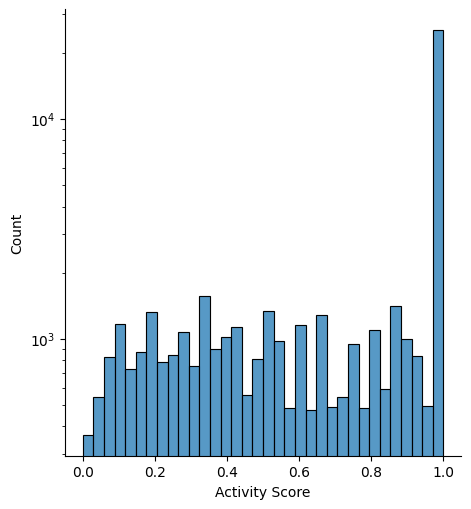

In [ ]:
sns.displot(label)
plt.yscale('log')
plt.xlabel('Activity Score')